## Importing

In [1]:
## %cd /Users/bezdek/Box/DCL_ARCHIVE/Documents/Events/exp148_Corpus/viz

import pickle as pkl
import pandas as pd
import numpy as np

# For panel visualizations:
import panel as pn
#import param
# For displaying images:
import cv2
from IPython.display import clear_output, Image, display, HTML
from scipy.spatial.distance import cosine
from scipy.ndimage import gaussian_filter1d
from glob import glob
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from run_sem_with_features import preprocess_skel

pn.extension()

## Initializing Variables and Widgets

In [2]:
title = '# Visualize Input Features'
    
# Load sample input dfs:
runs = glob('output/skel/*_kinect_skel_features.csv')
runs = [os.path.basename(x).split('_')[0] for x in runs]
run_select = pn.widgets.Select(name='Select Run', options=runs, value=runs[0])
skel_checkbox = pn.widgets.Checkbox(name='Display Skeleton?')
obj_checkbox = pn.widgets.Checkbox(name='Display Nearest Objects?')
z_checkbox = pn.widgets.Checkbox(name='Z-score time courses?')
# Options and values for these widgets are just placeholders, will be updated based on run by listen_to_run 
frame_slider = pn.widgets.DiscreteSlider(name='Select Frame', options=list([0, 1, 2, 3]), value=0)
text_input = pn.widgets.TextInput(name='Second', placeholder='Enter timepoint (in second)')
second_slider = pn.widgets.DiscreteSlider(name='Select Second', options=list([0, 1, 2, 3]), value=0)
tc_feature_select = pn.widgets.MultiSelect(name='Select Time Course Features', value=['features[3]', 'features[4]'], options=['features[3]','features[4]'], size=8)
pair_feature_select = pn.widgets.MultiSelect(name='Select 2 or 3 Features for Comparison', value=['features[3]' ,'features[4]'],options=['features[3],features[4]'], size=8)


second_interval = 1 # interval to group boundaries
frame_per_second = 3 # sampling rate to input to SEM
fps = 25.0 # kinect videos
frame_interval = frame_per_second * second_interval

# declare global variables that will be used for each individual runs (to save loading time)
skel_df, appear_df, flow_df, objdf, objhand_df, anchored_frames, appear_df_post, flow_df_post, skel_df_post, gt_freqs, \
sem_readouts, inputdf, first_frame, offset, pca_input_df, pred_skel_df, skel_df_unscaled,categories, pred_objhand, word2vec = [None] * 20

glove_vectors = pkl.load(open('gen_sim_glove_50.pkl', 'rb'))

## Linking Widgets and Updating Global Variables

In [3]:
def second_to_frame(frame_slider, second):
    frameid = int(float(second.new) * 25)
    while frameid not in anchored_frames:
        frameid += 1
    frame_slider.value = frameid
second_slider.link(frame_slider, callbacks={'value': second_to_frame})
def text_to_secondsl(second_slider, text):
    second = int(text.new)
    second_slider.value = second
text_input.link(second_slider, callbacks={'value': text_to_secondsl})

@pn.depends(run_select.param.value)
def listen_to_run(run_select):
    global skel_df, appear_df, flow_df, objdf, objhand_df, anchored_frames, appear_df_post, flow_df_post, skel_df_post, \
        gt_freqs, sem_readouts, inputdf, first_frame, offset, pca_input_df, pred_skel_df, skel_df_unscaled,categories, pred_objhand, word2vec
    # These are dataframes before processing (standardizing, interpolating, concatenating, dropna, resample)
    skel_df=pd.read_csv(f'output/skel/{run_select}_kinect_skel_features.csv')
    appear_df = pd.read_csv(f'output/appear/{run_select}_kinect_appear.csv')
    flow_df=pd.read_csv(f'output/vid/{run_select}_kinect_video_features.csv')
    # Caching frames to speed up interactive time
    anchored_frames = pkl.load(open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_frames.pkl', 'rb'))
    # This data is for plotting diagnostic results
    gt_freqs = pkl.load(open(f'output/run_sem/{run_select}_kinect_trimjan_27_pca_gtfreqs.pkl', 'rb'))
    sem_readouts = pkl.load(open(f'output/run_sem/{run_select}_kinect_trimjan_27_pca_diagnostic.pkl', 'rb'))
    # Preprocess likelihoods because old_lik contains new likelihoods and repeat likelihoods as well
    sem_readouts['frame_dynamics']['old_lik'] = [[l for l in all_lik if
                                                  not(np.isclose(l, new_lik, rtol=1e-2) or np.isclose(l, repeat_lik, rtol=1e-2))]
                                                 for all_lik, new_lik, repeat_lik in
                                                 zip(sem_readouts['frame_dynamics']['old_lik'], sem_readouts['frame_dynamics']['new_lik'], sem_readouts['frame_dynamics']['repeat_lik'])]
    sem_readouts['frame_dynamics']['old_lik']  = [l if len(l) else [-5000] for l in sem_readouts['frame_dynamics']['old_lik']]
    sem_readouts['frame_dynamics']['old_prior'] = [[p for p in all_prior if
                                              not(np.isclose(p, new_prior, rtol=1e-2) or np.isclose(p, repeat_prior, rtol=1e-2))]
                                             for all_prior, new_prior, repeat_prior in
                                             zip(sem_readouts['frame_dynamics']['old_prior'], sem_readouts['frame_dynamics']['new_prior'], sem_readouts['frame_dynamics']['repeat_prior'])]
    sem_readouts['frame_dynamics']['old_prior']  = [p if len(p) else [-5000] for p in sem_readouts['frame_dynamics']['old_prior']]
    # A list of dataframes after processing (appear->flow->skel->objhand). It also contains other dataframes for plotting (3 nearest_objects->object_coordinates)
    # and x_train and x_inferred of SEM.
    inputdf = pkl.load(open(f'output/run_sem/{run_select}_kinect_trimjan_27_pca_inputdf.pkl', 'rb'))
    # offset to align prediction boundaries with exact video timepoint
    first_frame = inputdf[0].index[0]
    offset = first_frame / fps / second_interval
    
    appear_df_post = inputdf[0]
    flow_df_post = inputdf[1]
    skel_df_post = inputdf[2]
    objhand_df = inputdf[3]
    objdf = inputdf[5]

    # Prepare dataframes to plot input skeleton and predicted skeleton
    pca_input_df = inputdf[6]
    pred_skel_df = inputdf[7]
    skel_df_unscaled = skel_df_post.copy().loc[:, skel_df_post.columns]
    pred_skel_df = pred_skel_df.loc[:, skel_df_post.columns]
    pca_input_df = pca_input_df.loc[:, skel_df_post.columns]

    skel_df_unscaled = skel_df_unscaled * skel_df.std() + skel_df.mean()
    pred_skel_df = pred_skel_df * skel_df.std() + skel_df.mean()
    pca_input_df = pca_input_df * skel_df.std() + skel_df.mean()

    skel_df_unscaled['frame'] = skel_df_unscaled.index
    pred_skel_df['frame'] = pred_skel_df.index
#     pca_input_df['frame'] = pca_input_df.index
    pca_input_df.set_index(pred_skel_df.index, inplace=True)
    pca_input_df['frame'] = pca_input_df.index # This is a workaround, will remove after new results come
    for i in range(25):
        new_column = f'J{i}_Tracked'
        skel_df_unscaled[new_column] = 'Inferred'
        pred_skel_df[new_column] = 'Predicted'
        pca_input_df[new_column] = 'Inferred'
    # Prepare a dictionary of word2vec for this particular run
    categories = set()
    for c in inputdf[4].columns:
        categories.update(inputdf[4].loc[:, c])
    if None in categories:
        categories.remove(None)

    pred_objhand = inputdf[7]
    pred_objhand = pred_objhand.loc[:, objhand_df.drop(['euclid', 'cosine'], axis=1, errors='ignore').columns]
    word2vec = dict()
    for category in categories:
        r = np.zeros(shape=(1, pred_objhand.shape[1]))
        try:
            r += glove_vectors[category]
        except Exception as e:
            words = category.split(' ')
            for w in words:
                w = w.replace('(', '').replace(')', '')
                r += glove_vectors[w]
            r /= len(words)
        word2vec[category] = r
    # Add two new distances columns to objhand_df
    i=1
    dists=[0]
    euc_dists = [0]
    while i < len(objhand_df):
        dists.append(cosine(objhand_df.iloc[i],objhand_df.iloc[i-1]))
        euc_dists.append(np.linalg.norm(objhand_df.iloc[i] - objhand_df.iloc[i-1]))
        i+=1
    objhand_df['cosine']=dists
    objhand_df['euclid'] = euc_dists

    # Update sliders
    frame_slider.options = list(anchored_frames.keys())
    frame_slider.value=list(anchored_frames.keys())[0]
    second_slider.options=list(np.arange(inputdf[0].index[0] // 25, inputdf[0].index[-1] // 25))
    second_slider.value=inputdf[0].index[0] // 25

    features = skel_df_post.columns.tolist()
    tc_feature_select.options = features
    tc_feature_select.value = [features[3],features[4]]
    pair_feature_select.options=features
    pair_feature_select.value=[features[3],features[4]]


## Appear Features

In [4]:
@pn.depends(frame_slider.param.value,run_select.param.value)
def appear_plot(frame_slider,run_select): # start function
    # appear_df = pd.read_csv('output/appear/'+run_select+'_kinect_appear.csv')
    df = appear_df.reset_index()
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='appear', ax=ax)
    df.plot(kind='line', x='second', y='disappear', ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Appearances and Disappearances '+run_select)
    #ax.get_legend().remove()
    #plt.show()
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value,run_select.param.value)
def appear_plot_post(frame_slider,run_select): # start function
    # appear_df = pd.read_csv('output/appear/'+run_select+'_kinect_appear.csv')
    df = appear_df_post.reset_index()
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='appear', ax=ax)
    df.plot(kind='line', x='second', y='disappear', ax=ax)
    ax.axvline(frame_slider,linewidth=3, color = 'r', alpha=0.5)
    plt.title('Appearances and Disappearances Post'+run_select)
    #ax.get_legend().remove()
    #plt.show()
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    plt.close(fig)
    return fig

## Skeleton Features

In [5]:
@pn.depends(tc_feature_select.param.value, frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def time_plot(tc_feature_select,frame_slider,z_checkbox,run_select): # start function
    # skel_df=pd.read_csv('output/skel/'+run_select+'_kinect_skel_features.csv')
    fps = 25.0 # kinect video frame rate
    skel_df['frame'] = (skel_df['sync_time'] * fps).apply(round).astype(int)
    df = skel_df.reset_index()
    if z_checkbox:
        for feat in tc_feature_select:
            df[feat] = (df[feat] - df[feat].mean())/df[feat].std(ddof=0)
            #df[feat]=df[feat].apply(zscore)
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    for feat in tc_feature_select:
        df.plot(kind='line', x='second', y=feat, alpha = 0.5,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Feature Time Course '+run_select)
    #plt.show()
    plt.close(fig)
    return fig

@pn.depends(pair_feature_select.param.value, frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def pair_plot(pair_feature_select,frame_slider,z_checkbox,run_select): # start function
    skel_df['frame'] = (skel_df['sync_time'] * fps).apply(round).astype(int)
    df = skel_df.reset_index()
    if z_checkbox:
        for feat in pair_feature_select:
            df[feat] = (df[feat] - df[feat].mean())/df[feat].std(ddof=0)
    pdf = df[df['frame'] == frame_slider]
        
    if len(pair_feature_select) == 2:
        fig,ax = plt.subplots()
        df.plot(kind='scatter', x=pair_feature_select[0], y=pair_feature_select[1],alpha=0.5,c=df['frame'],colormap='viridis',ax=ax)
        ax.plot(pdf[pair_feature_select[0]],pdf[pair_feature_select[1]],marker='o',markersize=15,color='r',alpha=0.5)
    elif len(pair_feature_select) == 3:
        fig,ax=plt.subplots(subplot_kw=dict(projection='3d'))
        p=ax.scatter(df[pair_feature_select[0]],df[pair_feature_select[1]],df[pair_feature_select[2]],c=df['frame'],cmap='viridis')
        ax.plot(pdf[pair_feature_select[0]],pdf[pair_feature_select[1]],pdf[pair_feature_select[2]],marker='o',markersize=15,color='r')
        ax.set_xlabel(pair_feature_select[0])
        ax.set_ylabel(pair_feature_select[1])
        ax.set_zlabel(pair_feature_select[2])

        fig.colorbar(p)
    else:
        fig,ax = plt.subplots()
    plt.title('Compare Features '+run_select)
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_reduced_features(frame_slider, run_select):

    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=2, whiten=True)
    x_train = pca.fit_transform(x_train)
    df = pd.DataFrame(x_train, index=skel_df_post.index, columns=['pc_1', 'pc_2'])
    fig, ax = plt.subplots()
    df.plot(kind='scatter', x=df.columns[0], y=df.columns[1],alpha=0.5,c=df.index,colormap='viridis',ax=ax)
    ax.plot(df.loc[frame_slider, 'pc_1'], df.loc[frame_slider, 'pc_2'], marker='o',markersize=15,color='r',alpha=0.5)
    ax.set_title('Principal Components for Skeletons')
    ax.axvline(frame_slider,linewidth=3, color = 'r', alpha=0.5)
    plt.close()
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def skel_plot_post(frame_slider, run_select):

    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=0.9, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(cosine(x_train[i], x_train[-1]))
    df = pd.DataFrame(change, index=skel_df_post.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)
    fig, ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Skel PCA Cosine Disntance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) * 100)}% variance')
    plt.close()
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def skel_plot_post_euclid(frame_slider, run_select):

    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=0.9, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(np.linalg.norm(x_train[i] - x_train[-1]))
    df = pd.DataFrame(change, index=skel_df_post.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)
    fig, ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Skel PCA Euclidean Distance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) * 100)}% variance')
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    plt.close()
    return fig

## Object-Hand Features

In [6]:


@pn.depends(frame_slider.param.value,run_select.param.value)
def objhand_plot(frame_slider,run_select): # start function
    x_train = objhand_df.drop(['cosine', 'euclid'], errors='ignore').to_numpy()
    pca = PCA(n_components=0.9, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(np.linalg.norm(x_train[i] - x_train[-1]))
    df = pd.DataFrame(change, index=objhand_df.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)
    fig, ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Objhand PCA Euclid Distance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) * 100)}% variance')

    
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    #plt.show()
    plt.close(fig)
    return fig

## Video Features

In [7]:

@pn.depends(frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def flow_plot(frame_slider,z_checkbox,run_select): # start function
    # flow_df=pd.read_csv('output/vid/'+run_select+'_kinect_video_features.csv')
    df = flow_df.reset_index()
    if z_checkbox:
        df['pixel_correlation'] = (df['pixel_correlation'] - df['pixel_correlation'].mean())/df['pixel_correlation'].std(ddof=0)
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='pixel_correlation', ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Interframe Pixel Correlation '+run_select)
    ax.get_legend().remove()
    #plt.show()
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def flow_plot_post(frame_slider,z_checkbox,run_select): # start function
    # flow_df=pd.read_csv('output/vid/'+run_select+'_kinect_video_features.csv')
    df = flow_df_post.reset_index()
    if z_checkbox:
        df['optical_flow_avg'] = (df['optical_flow_avg'] - df['optical_flow_avg'].mean())/df['optical_flow_avg'].std(ddof=0)
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df['optical_flow_avg'] = gaussian_filter1d(df['optical_flow_avg'].values, 5)
    df.plot(kind='line', x='second', y='optical_flow_avg', ax=ax, alpha=0.5)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Interframe Optical Flow Post '+run_select)
    ax.get_legend().remove()
    # Plotting diagnostic embeded in a function

    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    #plt.show()
    plt.close(fig)
    return fig


## Impose Skeletons and Objects on Frame

In [8]:
def drawskel(frame_number,frame,skel_df,color=(255,0,0),thickness=2):
    # frame_number : video frame to select skeleton joints
    # frame : image frame to draw on
    # skel_df : df of skeleton joint coordinates
    # color : RGB tuple for color
    # thinkness : thickness to draw bone lines

    # Find scale factor of video frame. Original skeleton 2D dimensions are 1080 x 1920
    s = frame.shape[0]/1080.0
    #ys = frame.shape[1]/1920.0
    #xs=1.0
    #ys=1.0
    r=skel_df[skel_df['frame'] == frame_number]
    def seg(bone,f):
        # draw segment between two joints
        ax = int(r['J'+str(bone[0])+'_2D_X'].values[0] * s)
        ay = int(r['J'+str(bone[0])+'_2D_Y'].values[0] * s)
        bx = int(r['J'+str(bone[1])+'_2D_X'].values[0] * s)
        by = int(r['J'+str(bone[1])+'_2D_Y'].values[0] * s)
        #print(ax,ay,bx,by)
        if all(x > 0 for x in (ax,ay,bx,by)):
            cv2.line(f,(ax,ay),(bx,by),color,thickness)
        return f
    for bone in [(3,2),(2,20),(20,1),(1,0),
                (21,7),(7,6),(22,6),(6,5),(5,4),(4,20),
                (20,8),(8,9),(9,10),(24,10),(10,11),(11,23),
                (0,12),(12,13),(13,14),(14,15),
                (0,16),(16,17),(17,18),(18,19)]:
        frame = seg(bone,frame)
    # Draw tracked vs inferred joints:
    for joint in range(25):
        jx = int(r['J'+str(joint)+'_2D_X'].values[0] * s)
        jy = int(r['J'+str(joint)+'_2D_Y'].values[0] * s)
        jtrack = r['J'+str(joint)+'_Tracked'].values[0]
        if (all(x > 0 for x in [jx,jy])):
            cv2.circle(frame,(jx,jy),4,color,-1)
#             if jtrack=='Tracked':
#                 #draw tracked joint
#                 cv2.circle(frame,(jx,jy),4,(0,255,0),-1)
#             elif jtrack=='Inferred':
#                 #draw inferred joint
#                 cv2.circle(frame,(jx,jy),4,(0,0,255),-1)
#             elif jtrack=='Predicted':
#                 cv2.circle(frame,(jx,jy),4,(255,0,0),-1)
    return frame


def get_nearest(pred_vector: np.ndarray, number_of_objects=2):
    res = {kv[0]: np.linalg.norm(kv[1] - pred_vector) for kv in word2vec.items()}
    res = sorted(res.items(), key=lambda kv: kv[1])
    res = [r[0] for r in res]
    return res
def drawobj(frame_number,frame,objdf, color=(255,0,0),thickness=1):
    odf=objdf[objdf.index==frame_number]
    odf=odf[odf.columns[~odf.isna().any()].tolist()]
    instances=set([x.split('_')[0] for x in odf.columns])
    s = frame.shape[0]/540.0
    for i in instances:
        xmin=odf[i+'_x'] * s
        ymin=odf[i+'_y'] * s
        xmax=xmin+(odf[i+'_w'] * s)
        ymax=ymin+(odf[i+'_h'] * s)
        try:
            conf_score =float(odf[i+'_confidence'])
            color = tuple(map(int, np.array(color) * conf_score))
        except:
            color = (0,0,255)
        cv2.rectangle(frame, pt1=(int(xmin), int(ymin)),
                      pt2=(int(xmax), int(ymax)),
                      color=color, thickness=thickness)
        cv2.putText(frame, text=i,
                    org=(int(xmin), int(ymax - 5)),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.4,
                    color=color)

    return frame

@pn.depends(frame_slider.param.value,skel_checkbox.param.value,obj_checkbox.param.value,run_select.param.value)
def draw_frame_resampled(frame_slider, skel_checkbox, obj_checkbox,run_select):
    # with open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_frames.pkl', 'rb') as f:
    #     anchored_frames = pkl.load(f)
    outframe = anchored_frames[frame_slider]
    # draw skeleton here
    if skel_checkbox:
        try:
            
            # outframe = drawskel(frame_slider,outframe,skel_df)
            outframe = drawskel(frame_slider,outframe,pred_skel_df,color=(0, 255, 0))
            outframe = drawskel(frame_slider,outframe,pca_input_df,color=(255, 0, 0))
        except:
            cv2.putText(outframe,'No skeleton data',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
    else:
        outframe = anchored_frames[frame_slider]
    if obj_checkbox:
        nearest_objects = get_nearest(pred_objhand.loc[frame_slider, :].values)
        print(nearest_objects[:3])
        outframe = drawobj(frame_slider, outframe, objdf)
        for index, instance in enumerate(nearest_objects[:3]):
            cv2.putText(outframe, text=instance, org=(outframe.shape[1]-100, 20 + 20*index),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                        color=(0, 255, 0))
    outframe=Image(data=cv2.imencode('.png', outframe)[1])
    return outframe

## SEM DIAGNOSTIC READOUTS

In [9]:
@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_diagnostic_readouts(frame_slider, run_select, title=''):


    fig, ax = plt.subplots()
    ax.plot(gaussian_filter1d(gt_freqs, 1), label='Subject Boundaries')
    ax.set_xlabel('Time (second)')
    ax.set_ylabel('Boundary Probability')
    ax.set_title('Diagnostic Readouts '+run_select)
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}

    latest = 0
    current = 0
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')

    df = pd.DataFrame(switch, columns=['switch'])

    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')

    ax.legend()
    ax.set_ylim([0, 1.0])
    plt.close()
    return fig


@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_likelihood(frame_slider, run_select):

    sem_readouts['frame_dynamics']['old_lik'] = list(map(np.max, sem_readouts['frame_dynamics']['old_lik']))

    fig, ax = plt.subplots()
    df = pd.DataFrame(sem_readouts['frame_dynamics'], index=inputdf[0].index[1:])
    df['second'] = df.index / 25
    df.plot(kind='line', x='second', y='new_lik',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='old_lik',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='repeat_lik',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='restart_lik',alpha=1.00,ax=ax)

    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    ax.set_ylim([-3, 3])
    ax.legend()
    ax.set_title('Likelihood '+run_select)
    ax.set_ylabel('Log-likelihood')
    ax.set_xlabel('Time (second)')
    plt.close()
    return fig


@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_prior(frame_slider, run_select):

    sem_readouts['frame_dynamics']['old_prior'] = list(map(np.max, sem_readouts['frame_dynamics']['old_prior']))
    
    fig, ax = plt.subplots()
    df = pd.DataFrame(sem_readouts['frame_dynamics'], index=inputdf[0].index[1:])
    df['second'] = df.index / 25
    df.plot(kind='line', x='second', y='new_prior',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='old_prior',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='repeat_prior',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='restart_prior',alpha=1.00,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    ax.set_ylim([-3, 3])
    ax.legend()
    ax.set_title('Prior '+run_select)
    plt.close()
    return fig

## Dashboard Arrangement

Column
    [0] Row
        [0] Markdown(str)
    [1] Row
        [0] Select(options=['1.1.1', '1.1.2', ...], value='1.1.1')
        [1] ParamFunction(function)
    [2] Row
        [0] Column
            [0] DiscreteSlider(formatter='%d', name='Select Frame', options=[114, 120, 129, ...], value=114, value_throttled=0)
            [1] DiscreteSlider(formatter='%d', name='Select Second', options=[4, 5, 6, 7, 8, ...], value=4, value_throttled=0)
            [2] TextInput(name='Second', placeholder='Enter timepoint (...)
        [1] Column
            [0] Checkbox(name='Display Skeleton?')
            [1] Checkbox(name='Display Nearest O...)
            [2] Checkbox(name='Z-score time courses?')
    [3] Row
        [0] Column
            [0] ParamFunction(function)
            [1] ParamFunction(function)
            [2] ParamFunction(function)
        [1] Column
            [0] ParamFunction(function)
            [1] ParamFunction(function)
            [2] ParamFunction(function)
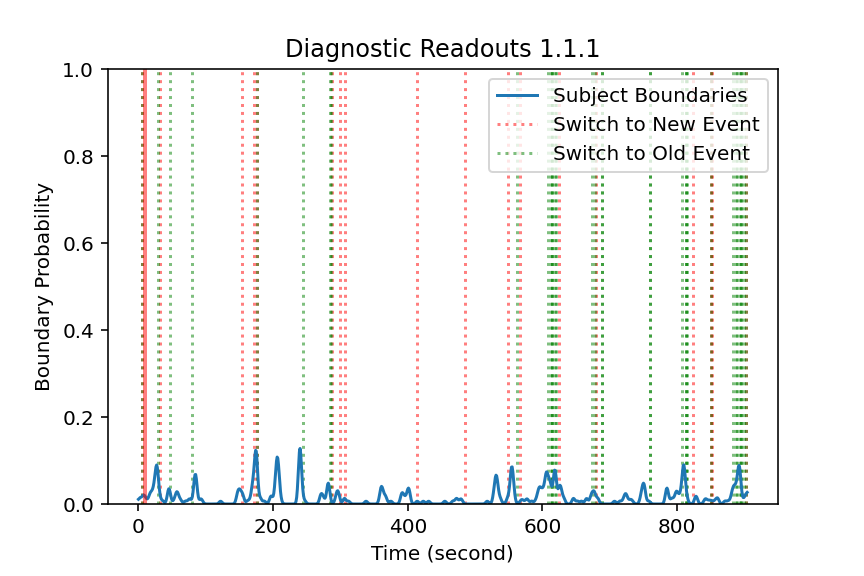
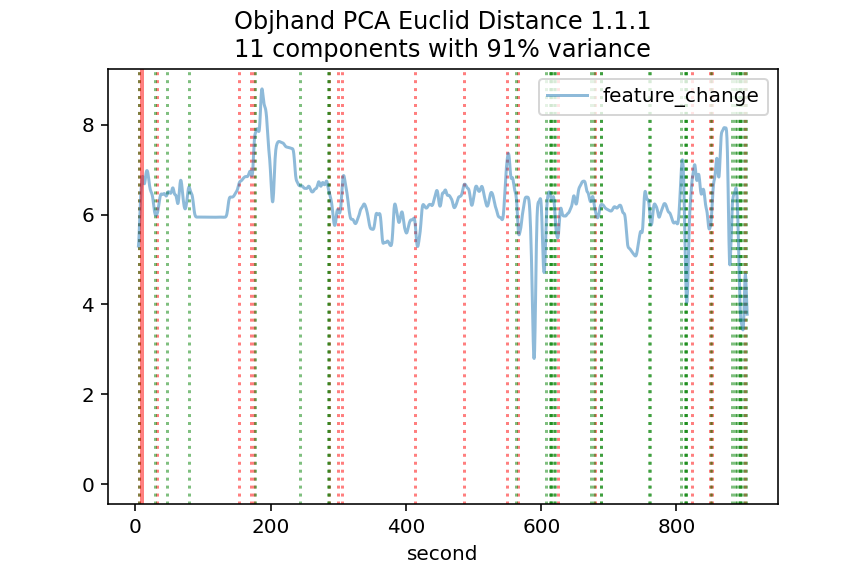
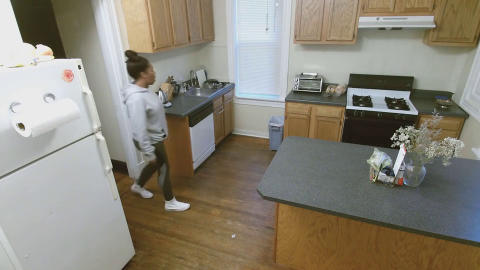
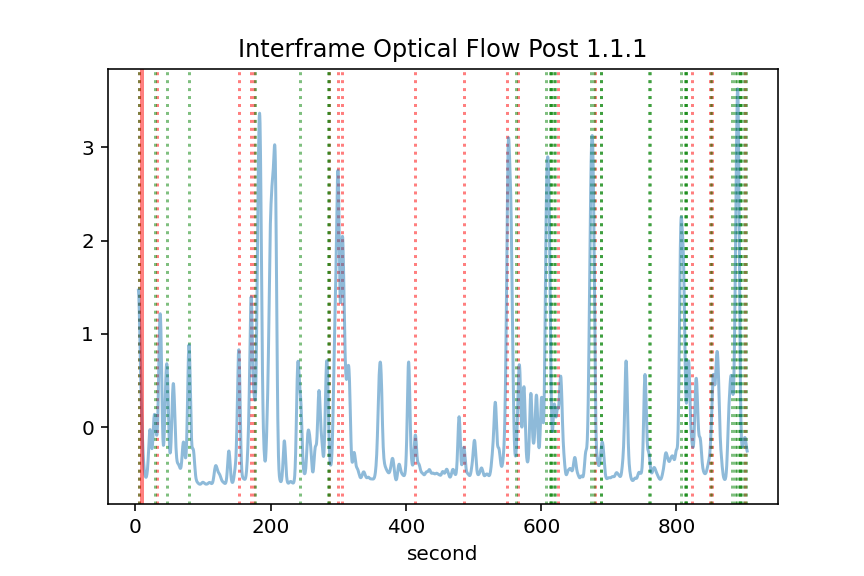
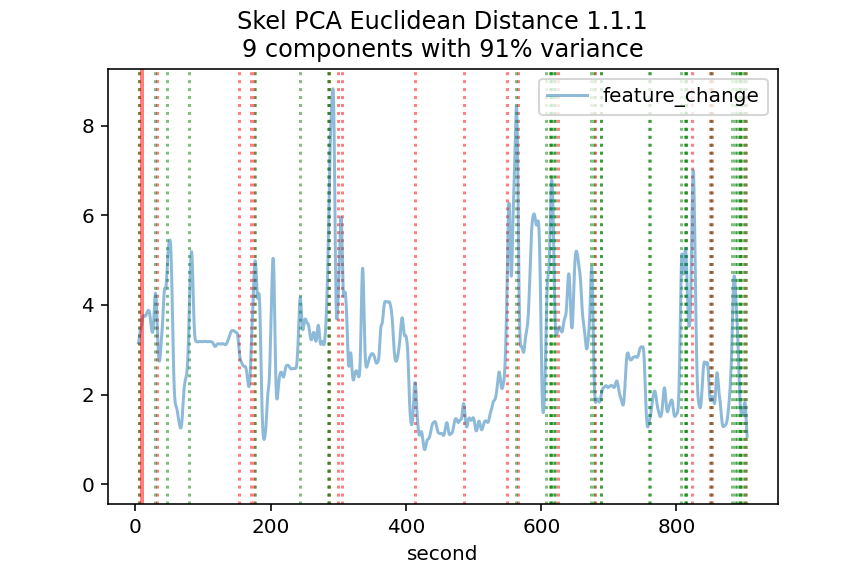
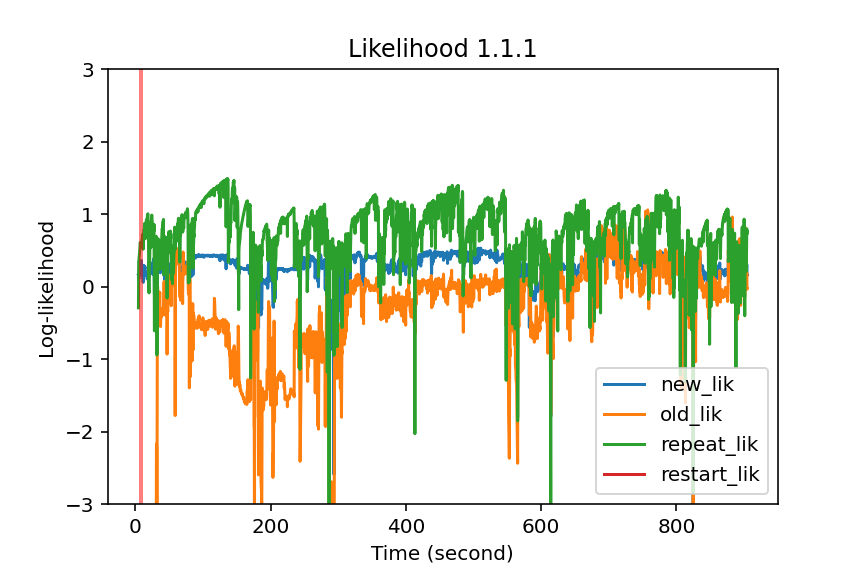

In [10]:
dashboard = pn.Column(
    pn.Row(title),
    pn.Row(run_select, listen_to_run),
    pn.Row(pn.Column(frame_slider, second_slider,text_input), pn.Column(skel_checkbox,obj_checkbox,z_checkbox)),
    pn.Row(pn.Column(flow_plot_post, objhand_plot, skel_plot_post_euclid), 
           pn.Column(draw_frame_resampled, plot_diagnostic_readouts, plot_likelihood))
)

# Launch the dashboard
dashboard.servable()

In [11]:
# runs = glob('output/skel/*_kinect_skel_features.csv')
# runs = [os.path.basename(x).split('_')[0] for x in runs]
# run_select = pn.widgets.Select(name='Select Run', options=runs, value=runs[0])
# frame_slider = pn.widgets.DiscreteSlider(name='Select Frame', options=list(np.arange(30)), value=10)
# text_input = pn.widgets.TextInput(name='Second', placeholder='Enter timepoint (in second)')
# second_slider = pn.widgets.DiscreteSlider(name='Select Second', options=list(np.arange(inputdf[0].index[-1] // 25)), value=0)
# x = 'x'
# y = 'y'

# @pn.depends(run_select.param.value)
# def listen_to_run(run_select):
#     global x, y
#     x = x + '_x'
#     y = y + '_y'
#     print(x, y)

# @pn.depends(frame_slider.param.value, run_select.param.value)
# def use_x(frame_slider, run_select):
#     print(f'run is {run_select}')
#     print(f'frame_slider is {frame_slider}')
#     print(f'x is {x}')
          
# def update_frame_slider(target, event):
#     target.options = list(np.arange(10))
#     print(target.options)
#     target.value=2
# run_select.link(frame_slider, callbacks={'value': update_frame_slider})

# dashboard = pn.Column(pn.Row(run_select, listen_to_run), pn.Row(use_x), pn.Row(frame_slider))

# # Launch the dashboard
# dashboard.servable()

In [12]:
glove_vectors.most_similar(positive=[pred_objhand.iloc[0, :]], topn=1)


ValueError: too many values to unpack (expected 2)